In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample

In [2]:
# Define filtering functions
def lowpass_filter(data, cutoff=15, fs=2175, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def bandpass_filter(data, lowcut=0.5, highcut=8, fs=30, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [6]:
# Cell 2: Define data augmentation function
def apply_gaussian_noise(signal, noise_std=0.02):
    noise = np.random.normal(0, noise_std, signal.shape)
    return signal + noise

In [7]:
def process_ppg_file(signal_path, label_path, target_sampling_rate=30, augment=False):
    signal_data = pd.read_csv(signal_path, header=None).values.flatten()
    label_data = pd.read_csv(label_path)
    
    filtered_signal = lowpass_filter(signal_data)
    original_sampling_rate = 2175
    num_samples = int(len(filtered_signal) * (target_sampling_rate / original_sampling_rate))
    downsampled_signal = resample(filtered_signal, num_samples)
    processed_signal = bandpass_filter(downsampled_signal, fs=target_sampling_rate)
    processed_signal = (processed_signal - np.mean(processed_signal)) / np.std(processed_signal)
    
    glucose_level = label_data['Glucose'].values[0]
    age = label_data['Age'].values[0]
    gender = 1 if label_data['Gender'].values[0] == 'Male' else 0
    
    augmented_signals = [processed_signal]
    
    if augment:
        for _ in range(3):  # Apply Gaussian noise 3 times per signal
            augmented_signals.append(apply_gaussian_noise(processed_signal))
    
    return [(sig, glucose_level, age, gender) for sig in augmented_signals]


In [9]:
def process_all_ppg_files(root_folder, output_file, augment=False):
    signal_folder = os.path.join(root_folder, "RawData")
    label_folder = os.path.join(root_folder, "Labels")
    
    if not os.path.exists(signal_folder):
        raise FileNotFoundError(f"Error: Signal folder not found at {signal_folder}")
    if not os.path.exists(label_folder):
        raise FileNotFoundError(f"Error: Label folder not found at {label_folder}")
    
    processed_data = []
    
    for signal_file in os.listdir(signal_folder):
        if signal_file.startswith('signal') and signal_file.endswith('.csv'):
            label_file = signal_file.replace('signal', 'label')
            signal_path = os.path.join(signal_folder, signal_file)
            label_path = os.path.join(label_folder, label_file)
            
            if os.path.exists(label_path):
                processed_data.extend(process_ppg_file(signal_path, label_path, augment=augment))
            else:
                print(f"Warning: No matching label file for {signal_file}")
    
    df = pd.DataFrame(processed_data, columns=['PPG_Signal', 'Glucose_Level', 'Age', 'Gender'])
    df.to_pickle(output_file)
    print(f"Processed data saved to {output_file}. Dataset size: {len(df)} samples.")

In [10]:
def plot_ppg_signals(pickle_file, num_samples=5):
    df = pd.read_pickle(pickle_file)
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(df))):
        ppg_signal = df.iloc[i]["PPG_Signal"]
        plt.plot(ppg_signal, label=f"Sample {i+1} (Glucose: {df.iloc[i]['Glucose_Level']} mg/dL)")
    plt.xlabel("Time (samples at 30Hz)")
    plt.ylabel("Normalized PPG Amplitude")
    plt.title("Visualization of Processed PPG Signals")
    plt.legend()
    plt.show()


Processed data saved to processed_ppg_data.pkl. Dataset size: 268 samples.


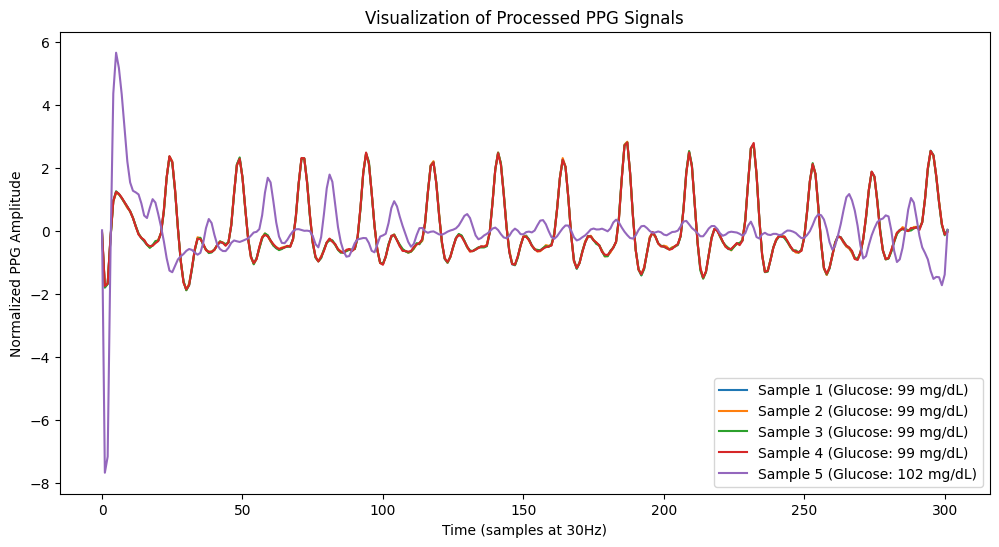

In [11]:
process_all_ppg_files("C:/Users/Tiddie Destroyer/Downloads/PPG_Dataset/PPG_Dataset", "processed_ppg_data.pkl", augment=True)
plot_ppg_signals("processed_ppg_data.pkl")


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def split_train_test(pickle_file, test_size=0.2, random_state=42):
    df = pd.read_pickle(pickle_file)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)  # Shuffle dataset
    
    X = np.array(df['PPG_Signal'].tolist())  # Convert list of arrays into a NumPy array
    y = df['Glucose_Level'].values  # Target variable
    
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)
    
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, scaler_y


In [44]:
# Cell 8: Train a Random Forest Model
def train_model(X_train, y_train, n_estimators=100, random_state=42):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [45]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    return mae, rmse

In [18]:
X_train, X_test, y_train, y_test = split_train_test("processed_ppg_data.pkl")
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

Train set size: 214, Test set size: 54
Mean Absolute Error: 3.01
Root Mean Squared Error: 4.61


(3.008518518518518, 4.6110591697208445)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, BatchNormalization, 
    Input, Conv1D, MaxPooling1D, Attention, Concatenate, 
    GRU, GlobalAveragePooling1D, Add, Layer, LayerNormalization,
    SpatialDropout1D, LeakyReLU, Reshape, Masking
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import json
import gc

In [12]:
def build_optimized_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
    return model

In [13]:
def train_optimized_lstm(X_train, y_train, X_test, y_test, model_path='optimized_lstm_model2.h5', epochs=150, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape for LSTM
    X_test = np.expand_dims(X_test, axis=-1)
    
    model = build_optimized_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
    model.save(model_path)
    print(f"Optimized model saved to {model_path}")
    return model

In [14]:
def evaluate_model(model, X_test, y_test, scaler_y):
    X_test = np.expand_dims(X_test, axis=-1)  # Ensure correct shape for predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions to original glucose scale
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Compute Metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.7, label='Predicted vs Actual')
    plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r', linestyle='--')
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Predicted vs. Actual Glucose Levels")
    plt.legend()
    plt.show()
    
    return mae, rmse, r2

In [15]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
lstm_model = train_optimized_lstm(X_train, y_train, X_test, y_test)


Train set size: 214, Test set size: 54
Epoch 1/150
7/7 [==============================] - 13s 993ms/step - loss: 0.0619 - mae: 0.1896 - val_loss: 0.1282 - val_mae: 0.2658 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 6s 783ms/step - loss: 0.0469 - mae: 0.1684 - val_loss: 0.1179 - val_mae: 0.2478 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 777ms/step - loss: 0.0390 - mae: 0.1473 - val_loss: 0.1103 - val_mae: 0.2358 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 6s 870ms/step - loss: 0.0355 - mae: 0.1422 - val_loss: 0.1052 - val_mae: 0.2280 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 5s 784ms/step - loss: 0.0315 - mae: 0.1325 - val_loss: 0.1016 - val_mae: 0.2229 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 6s 849ms/step - loss: 0.0310 - mae: 0.1342 - val_loss: 0.1013 - val_mae: 0.2224 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6s 846ms/step - loss:

2/2 [==============================] - 1s 126ms/step
Mean Absolute Error: 5.25
Root Mean Squared Error: 6.67
R² Score: 0.92


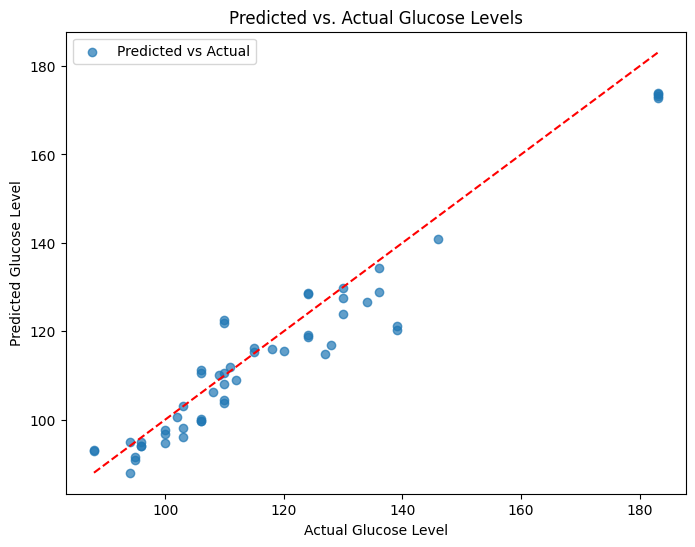

(5.252015855577256, 6.666913963090437, 0.9171724046957169)

In [16]:
evaluate_model(lstm_model, X_test, y_test, scaler_y)

In [3]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="attention_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="attention_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(SelfAttention, self).build(input_shape)
    
    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        ui = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ai = tf.nn.softmax(tf.tensordot(ui, self.u, axes=1), axis=1)
        ai = tf.expand_dims(ai, axis=-1)
        return tf.reduce_sum(x * ai, axis=1)

In [4]:
def build_advanced_lstm_model(input_shape, learning_rate=0.0001):
    """
    Builds an advanced LSTM model with attention mechanisms and residual connections
    
    Args:
        input_shape: Shape of input data (sequence_length, features)
        learning_rate: Learning rate for Adam optimizer
        
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Masking layer to handle variable-length sequences
    masked = Masking(mask_value=0.0)(inputs)
    
    # 1D CNN for feature extraction
    conv1 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(masked)
    conv1 = BatchNormalization()(conv1)
    conv1 = SpatialDropout1D(0.1)(conv1)
    
    conv2 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)
    conv2 = SpatialDropout1D(0.1)(conv2)
    
    # First LSTM layer with residual connection
    lstm1 = Bidirectional(LSTM(256, return_sequences=True, 
                              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                              recurrent_dropout=0.1))(conv2)
    lstm1 = LayerNormalization()(lstm1)
    
    # Second LSTM layer
    lstm2 = Bidirectional(LSTM(128, return_sequences=True,
                              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(lstm1)
    lstm2 = LayerNormalization()(lstm2)
    
    # Third GRU layer for sequence diversity
    gru = Bidirectional(GRU(64, return_sequences=True,
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(lstm2)
    gru = LayerNormalization()(gru)
    
    # Self-attention mechanism
    attention = SelfAttention()(gru)
    
    # Global average pooling for sequence summary
    gap = GlobalAveragePooling1D()(gru)
    
    # Concatenate attention and pooling
    concat = Concatenate()([attention, gap])
    
    # Dense layers with residual connections
    dense1 = Dense(128)(concat)
    dense1 = BatchNormalization()(dense1)
    dense1 = LeakyReLU(alpha=0.1)(dense1)
    dense1 = Dropout(0.2)(dense1)
    
    dense2 = Dense(64)(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = LeakyReLU(alpha=0.1)(dense2)
    dense2 = Dropout(0.2)(dense2)
    
    # Output layer
    outputs = Dense(1)(dense2)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='huber_loss',  # Huber loss is more robust to outliers
        metrics=['mae', 'mse']
    )
    
    return model


In [6]:
def prepare_ppg_data(data_path, test_size=0.2, validation_size=0.1, window_size=300, stride=150):
    """
    Prepare PPG signal data for model training
    
    Args:
        data_path: Path to the transformed PPG data CSV
        test_size: Fraction of data to use for testing
        validation_size: Fraction of training data to use for validation
        window_size: Size of the sliding window for segmentation
        stride: Stride of the sliding window
        
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test, scaler_y
    """
    # Load and preprocess data
    df = pd.read_csv(data_path)
    
    # Parse PPG_SIGNAL column from string to list
    df['PPG_SIGNAL'] = df['PPG_SIGNAL'].apply(lambda x: json.loads(x.replace('[', '[').replace(']', ']')))
    
    # Create segments
    X = []
    y = []
    
    for i, row in df.iterrows():
        ppg_signal = np.array(row['PPG_SIGNAL'])
        glycaemia = row['Glycaemia']
        
        # Check if the signal is long enough for segmentation
        if len(ppg_signal) >= window_size:
            # Create segments with sliding window
            for start in range(0, len(ppg_signal) - window_size + 1, stride):
                segment = ppg_signal[start:start + window_size]
                # Normalization within segment for relative amplitudes
                segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
                X.append(segment)
                y.append(glycaemia)
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X for LSTM input: (samples, time_steps, features)
    X = np.expand_dims(X, axis=-1)
    
    # Scale target variable
    scaler_y = RobustScaler()  # More robust to outliers than MinMaxScaler
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Split data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=True
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=validation_size / (1 - test_size),
        random_state=42, shuffle=True
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler_y

In [ ]:
def train_advanced_model(X_train, y_train, X_val, y_val, X_test, y_test, scaler_y, 
                         model_path='advanced_lstm_model.h5', 
                         epochs=200, batch_size=32, patience=20):
    """
    Train the advanced LSTM model with proper callbacks and evaluation
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Training, validation, and test data
        scaler_y: Scaler for target variable
        model_path: Path to save the trained model
        epochs: Maximum number of training epochs
        batch_size: Batch size for training
        patience: Patience for early stopping
        
    Returns:
        Trained model and evaluation metrics
    """
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Build model with smaller learning rate for fine-grained optimization
    model = build_advanced_lstm_model(input_shape, learning_rate=0.0001)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.2, 
        patience=patience//4, 
        min_lr=1e-7,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        model_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    # Train the model with class weights to handle imbalance if present
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        epochs=epochs, 
        batch_size=batch_size, 
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    # Load the best model
    model = tf.keras.models.load_model(
        model_path, 
        custom_objects={'SelfAttention': SelfAttention}
    )
    
    # Evaluate on test set
    mae, rmse, r2 = evaluate_advanced_model(model, X_test, y_test, scaler_y)
    
    # Plot training history
    plot_training_history(history)
    
    return model, mae, rmse, r2


In [7]:
def evaluate_advanced_model(model, X_test, y_test, scaler_y):
    """
    Evaluate the advanced model and compute metrics
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test targets
        scaler_y: Scaler for target variable
        
    Returns:
        mae, rmse, r2: Evaluation metrics
    """
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions to original scale
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Compute metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Print metrics
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([min(y_test_original), max(y_test_original)], 
             [min(y_test_original), max(y_test_original)], 
             'r--')
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Actual vs. Predicted Glucose Levels")
    plt.grid(True, alpha=0.3)
    
    # Add metrics text to plot
    plt.figtext(0.15, 0.8, f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}", 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Error distribution
    plt.figure(figsize=(10, 6))
    errors = y_pred_original - y_test_original
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Prediction Errors")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return mae, rmse, r2

In [8]:
def plot_training_history(history):
    """
    Plot training and validation loss
    
    Args:
        history: Keras training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train')
    plt.plot(history.history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
gc.collect()
tf.keras.backend.clear_session()

# Prepare data
X_train, y_train, X_val, y_val, X_test, y_test, scaler_y = prepare_ppg_data(
    'processed_ppg_data.pkl',
    test_size=0.2,
    validation_size=0.1,
    window_size=300,  # Adjust based on your PPG signal characteristics
    stride=150        # Overlap for better generalization
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Train advanced model
model, mae, rmse, r2 = train_advanced_model(
    X_train, y_train, X_val, y_val, X_test, y_test, scaler_y,
    model_path='advanced_lstm_model.h5',
    epochs=200,  # Increased epochs with early stopping
    batch_size=32,
    patience=25  # More patience for convergence
)

# Final evaluation
print("\nFinal Evaluation Metrics:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'processed_ppg_data.pkl'